# Chapter 1 Distributional representation of natural language and words
## 2.3.1 파이썬으로 말뭉치 전처리하기

In [2]:
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
def preprocess(text):
    text = text.lower()
    text = text.replace(".", " .")
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word



### 2.3.4 동시발생 행렬

In [4]:
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

corpus
id_to_word

array([0, 1, 2, 3, 4, 1, 5, 6])

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [5]:
C = np.array([
    [0,1,0,0,0,0,0],
    [1,0,1,0,1,1,0],
    [0,1,0,1,0,0,0],
    [0,0,1,0,1,0,0],
    [0,1,0,1,0,0,0],
    [0,1,0,0,0,0,1],
    [0,0,0,0,0,1,0],
], dtype=np.int32)

print(C[0])
print(C[4])
print(C[word_to_id['goodbye']])

[0 1 0 0 0 0 0]
[0 1 0 1 0 0 0]
[0 1 0 1 0 0 0]


In [6]:
# 동시발생 행렬 만들기기
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] +=1

    return co_matrix

### 2.3.5 벡터 간 유사도

In [7]:
def cos_similarity(x, y, eps = 1e-8): # eps는 zero division error 방지 위함
    nx = x / np.sqrt(np.sum(x**2)) + eps # x의 정규화
    ny = y / np.sqrt(np.sum(y**2)) + eps # y의 정규화

    return np.dot(nx, ny)


In [8]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']] # 'you'의 단어 벡터
c1 = C[word_to_id['i']] # 'i'의 단어 벡터

print(cos_similarity(c0, c1))


0.7071067691154799


### 2.3.6 유사 단어의 랭킹 표시

In [9]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top = 5):
    # 검색어를 꺼낸다.
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return
    
    print('\n[query]' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    
    # 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count +=1
        if count >= top:
            return
        

In [10]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, most_similar

text = 'You say goodbye and I say hello'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)



[query] you
 hello: 0.9999999800000005
 i: 0.7071067691154799
 goodbye: 0.7071067691154799
 and: 0.0
 say: 0.0


## 2.4 통계 기반 기법 개선하기
### 2.4.1 상호정보량


In [11]:

def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i])+ eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt +=1
                if cnt % (total//100) == 0:
                    print('%.1f%% 완료' % (100*cnt / total))
    return M

In [12]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, most_similar

text = 'You say goodbye and I say hello'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3) # 유효 자릿수를 세 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0]
 [1 0 1 0 1 1]
 [0 1 0 1 0 0]
 [0 0 1 0 1 0]
 [0 1 0 1 0 0]
 [0 1 0 0 0 0]]
--------------------------------------------------
PPMI
[[0.    1.585 0.    0.    0.    0.   ]
 [1.585 0.    0.585 0.    0.585 1.585]
 [0.    0.585 0.    1.585 0.    0.   ]
 [0.    0.    1.585 0.    1.585 0.   ]
 [0.    0.585 0.    1.585 0.    0.   ]
 [0.    1.585 0.    0.    0.    0.   ]]


### 2.4.3 SVD에 의한 차원 감소

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[-1.110e-16  3.409e-01 -1.205e-01 -4.163e-16 -1.110e-16 -9.323e-01
 -2.426e-17]
[-1.110e-16  3.409e-01]


Text(-1.1102230246251565e-16, 0.34094876050949097, 'you')

Text(-0.5976364016532898, 0.0, 'say')

Text(-5.551115123125783e-17, 0.436312198638916, 'goodbye')

Text(-0.4978281259536743, 1.6653345369377348e-16, 'and')

Text(-3.123750637738718e-17, 0.436312198638916, 'i')

Text(-3.123750637738718e-17, 0.7092370986938477, 'hello')

Text(-0.6284886002540588, -1.942890293094024e-16, '.')

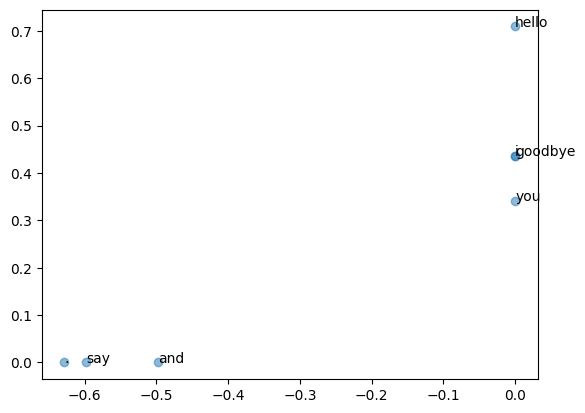

In [16]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)


print(C[0]) # 동시발생 행렬

print(W[0]) # PPMI 행렬

print(U[0]) # SVD

print(U[0, :2])


for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0],U[:,1], alpha=0.5)
plt.show()

### 2.4.4 PTB 데이터셋

In [17]:
import sys
sys.path.append('..')
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')

print('말뭉치 크기:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])



Done
말뭉치 크기: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


### 2.4.5 PTB 데이터셋 평가


In [20]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.util import most_similar, create_co_matrix, ppmi
from dataset import ptb


window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산 ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산 ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    # truncated SVD (빠르다!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (느리다)
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


동시발생 수 계산 ...
PPMI 계산 ...
1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
calculating SVD ...

[query] you
 i: 0.7006834745407104
 we: 0.6152541637420654
 anybody: 0.